# **Project Group 6**

#### **Team Members:**
| Name              | Student ID |
| ----------------- | ---------- |
| Danial Bashir   |   XXXXXX   | 
| Danial Rana   |   10122   |
| Danny Le  |   XXXXXX   |
| Christian Torhaug |   564355   |

# Problem Statement

This project investigates the volatility dynamics and interdependence between large-cap (S&P 500) and small-cap (Russell 2000) indices. The goal is to determine whether there are differences in their volatility behavior, dynamic correlation, and whether volatility leads or lags between the two groups.

Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.arima.model as sm
import statsmodels.stats.diagnostic as sd
from arch import arch_model
from mvgarch.mgarch import DCCGARCH
from mvgarch.ugarch import UGARCH
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2

#### Retrieving Data

In [4]:
# S&P 500
spx = pd.read_csv("S&P_500.csv")
spx['Date'] = pd.to_datetime(spx['Date'])
spx["Return"] = spx["Close"].pct_change()
spx = spx.dropna(subset={"Return"})

# Russell 2000
rut = pd.read_csv('Russell_2000.csv')
rut['Date'] = pd.to_datetime(rut['Date'])
rut["Return"] = rut["Close"].pct_change()
rut = rut.dropna(subset={"Return"})

Arima

In [ ]:
best_aic = np.inf
best_order = None
best_model = None

for p in range(6):
    for q in range(6):
        try:
            model = sm.ARIMA(spx['Close'], order=(p, 0, q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, 0, q)
                best_model = model
        except:
            continue
        
print(best_model.summary())
resid = best_model.resid
#model = sm.ARIMA(gasoline_data['Close'], order=(4, 0, 4)).fit()

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. U

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 9499
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -56867.864
Date:                Wed, 26 Mar 2025   AIC                         113743.728
Time:                        18:40:31   BIC                         113772.363
Sample:                             0   HQIC                        113753.445
                               - 9499                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1625.8605      0.000   5.06e+06      0.000    1625.860    1625.861
ar.L1          1.0000   7.08e-05   1.41e+04      0.000       1.000       1.000
ma.L1         -0.7845      0.001  -1298.543      0.0

### **Estimating Volatility Dynamics**

In [61]:
def fit_best_volatility_model(resid, model_type: str, symmetry: int):
    p_range = range(1, 5)
    q_range = range(1, 5)
    results = []

    for p in p_range:
        for q in q_range:
            try:
                model = arch_model(resid, vol=model_type, p=p, o=symmetry, q=q, dist='normal', rescale=False)
                fitted_model = model.fit(disp='off')
                results.append({
                    'p': p, 'q': q,
                    'model': model,
                    'fit': fitted_model,
                    'aic': fitted_model.aic,
                    'bic': fitted_model.bic
                })
            except Exception as e:
                print(f"Model {model_type}({p},{q}) failed: {e}")

    if not results:
        raise ValueError("No valid models were fitted.")

    best_fit = min(results, key=lambda x: x['aic'])  # select best by AIC
    return best_fit['fit']


Annualized Conditional Volatility: GARCH, EGARCH, TGARCH

In [62]:
def get_annualized_volatility(index: pd.DataFrame, model_type: str, symmetry: int):
    model = sm.ARIMA(index['Return'], order=(1, 0, 1)).fit()
    resid = model.resid

    fitted = fit_best_volatility_model(resid, model_type, symmetry)
    annual_vol = fitted.conditional_volatility * np.sqrt(252)

    mod = "TGARCH" if model_type == "GARCH" and symmetry == 1 else model_type
    return mod, index['Date'], annual_vol

Plotting Annualized Volatility

In [58]:
def plot_combined_volatilities(index: pd.DataFrame, index_name: str, smooth=False):
    models = [
        ("GARCH", 0, 'blue', '-', 'GARCH'),
        ("EGARCH", 0, 'orange', '-', 'EGARCH'),
        ("GARCH", 1, 'green', '-', 'TGARCH')
    ]

    plt.figure(figsize=(14, 6))
    for model_type, symmetry, color, style, label in models:
        label, dates, vol = get_annualized_volatility(index, model_type, symmetry)
        if smooth:
            vol = vol.rolling(window=10).mean()
        plt.plot(dates, vol, label=label, color=color, linestyle=style, alpha=0.8)

    plt.title(f'Annualized Conditional Volatility - {index_name}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()


c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\sit

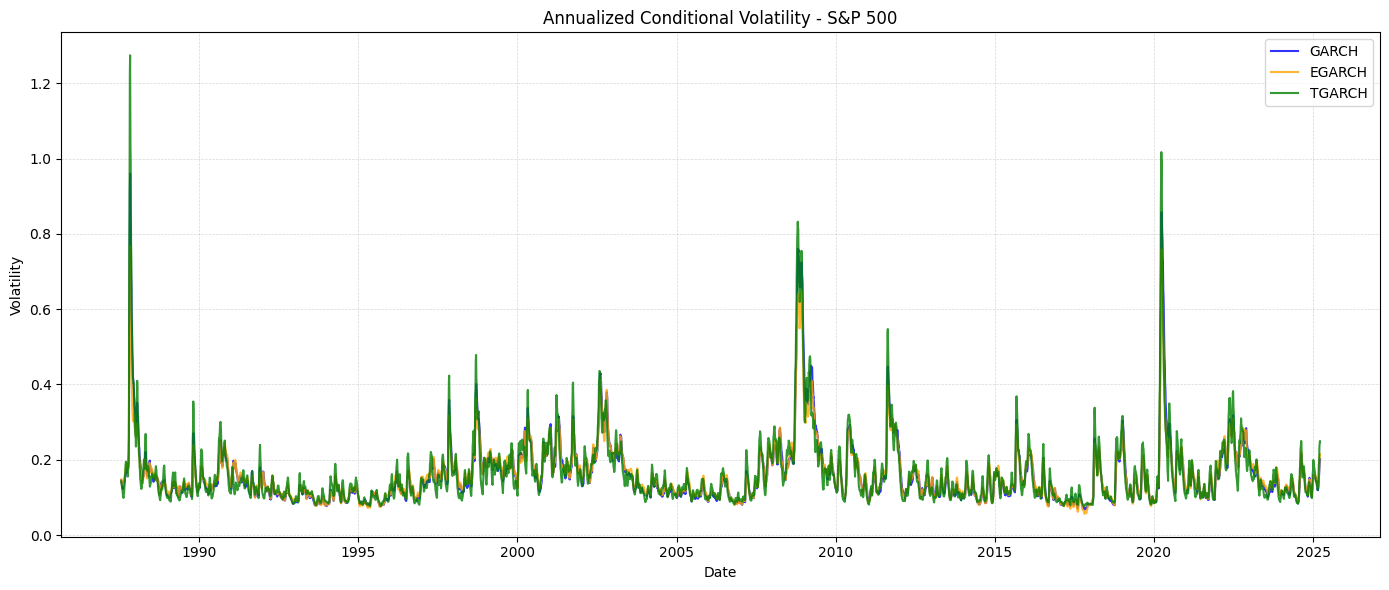

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\sit

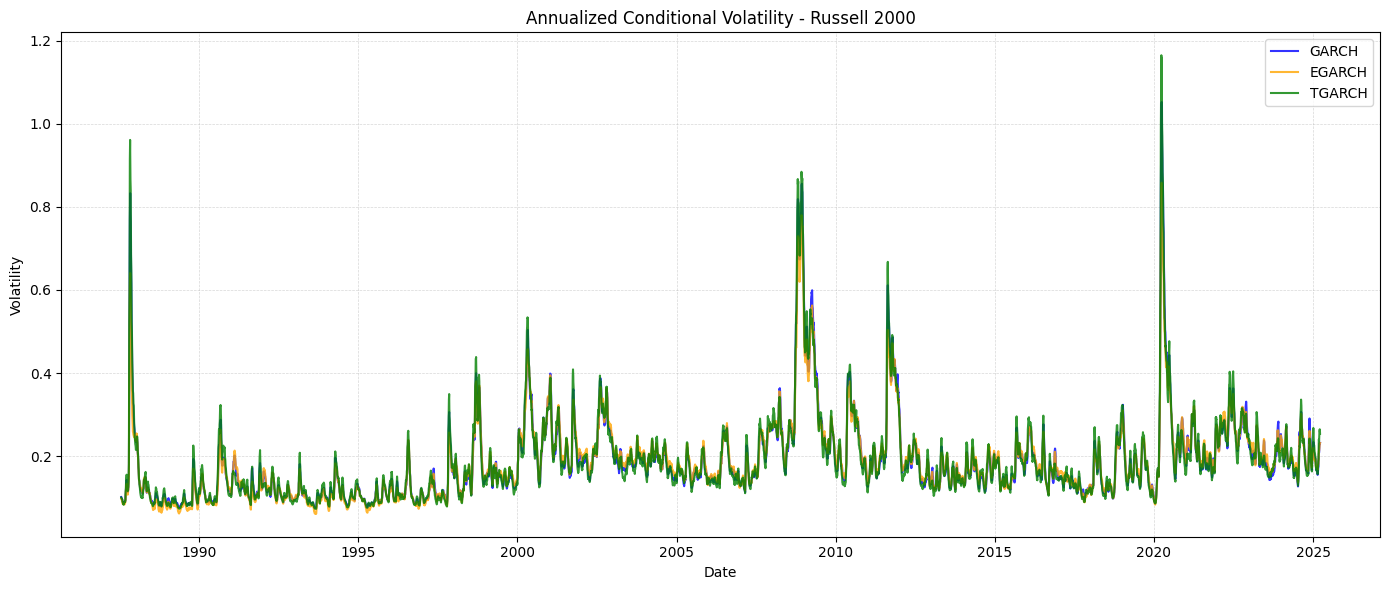

In [59]:
plot_combined_volatilities(spx, "S&P 500", smooth=True)
plot_combined_volatilities(rut, "Russell 2000", smooth=True)

Performance Evaluation: Mean Squared Error

In [66]:
indices = {'SPX': spx, 'RUT': rut}
models = [('GARCH', 0), ('EGARCH', 0), ('GARCH', 1)]
mse_results = []

for index_name, index_data in indices.items():
    actual_vol = index_data['Return'].rolling(window=30).std() * np.sqrt(252)
    for model_type, symmetry in models:
        try:
            _, _, predicted_vol = get_annualized_volatility(index_data, model_type, symmetry)

            df = pd.DataFrame({'actual': actual_vol, 'predicted': predicted_vol}).dropna()
            mse = mean_squared_error(df['actual'], df['predicted'])

            model_label = 'TGARCH' if model_type == 'GARCH' and symmetry == 1 else model_type
            mse_results.append({'Index': index_name, 'Model': model_label, 'MSE': mse})
        except Exception as e:
            continue

mse_df = pd.DataFrame(mse_results)
mse_df = mse_df.pivot(index='Model', columns='Index', values='MSE').round(6)
print(mse_df)

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\sit

Index        RUT       SPX
Model                     
EGARCH  0.001643  0.001602
GARCH   0.001435  0.000985
TGARCH  0.002433  0.002947


c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Performance Evaluation: Likelihood Ratio Test (LR Test)

In [ ]:
resid = sm.ARIMA(spx['Return'], order=(1, 0, 1)).fit().resid

garch_fit = fit_best_volatility_model(resid, "GARCH", 0)
egarch_fit = fit_best_volatility_model(resid, "EGARCH", 0)

lr_stat = 2 * (egarch_fit.loglikelihood - garch_fit.loglikelihood)
df = egarch_fit.num_params - garch_fit.num_params
p_value = 1 - chi2.cdf(lr_stat, df)

print(f"LR Stat: {lr_stat:.4f}, df: {df}, p-value: {p_value:.4f}")

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\sit

LR Stat: -10.9671, df: -2, p-value: nan


### **Time-varying Correlation**

Rolling Window Correlation

In [27]:
def rolling_correlation(df1, df2):
    windows = [30, 90, 180]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    plt.figure(figsize=(14, 6))

    for w, c in zip(windows, colors):
        rolling = df1['Return'].rolling(window=w).corr(df2['Return'])
        plt.plot(df1['Date'], rolling, label=f'{w}-Day Window', color=c, linestyle="--", linewidth=2)

    plt.title('Rolling Window Correlation (SPX vs RUT)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title='Window Size')
    plt.tight_layout()
    plt.show()

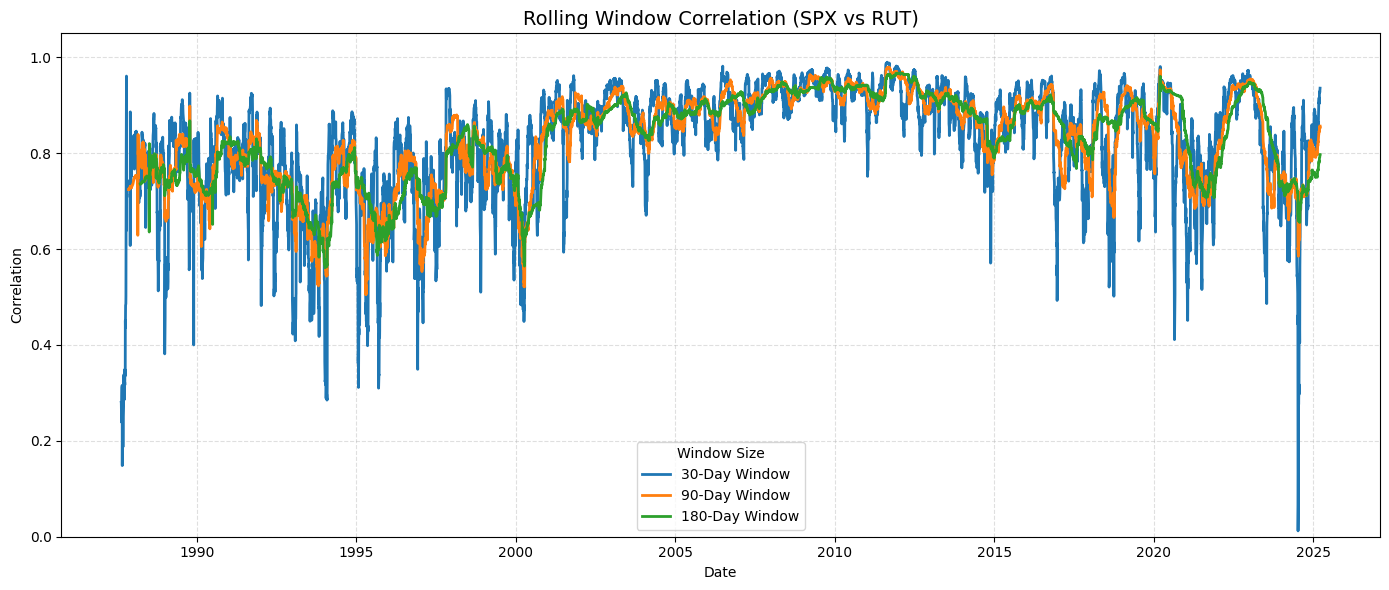

In [26]:
rolling_correlation(spx, rut)

EWMA (Exponentially Weighted Moving Average)

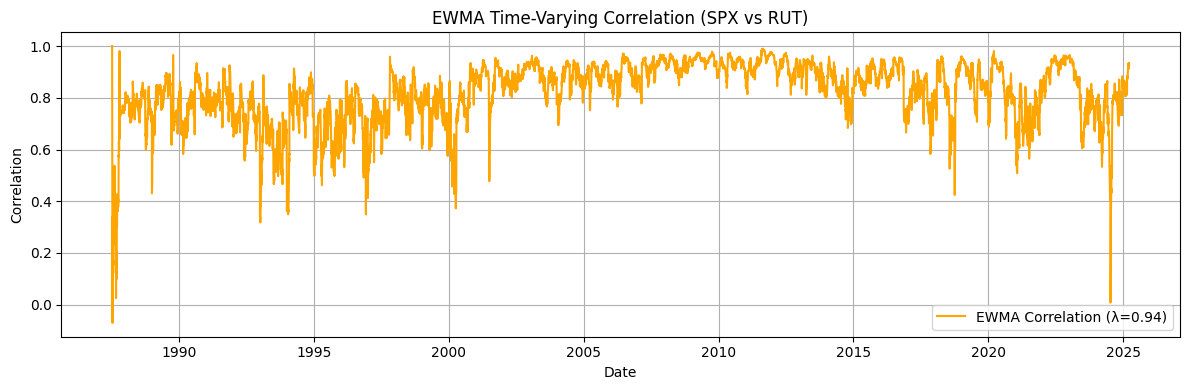

In [29]:
def ewma_cov_corr(df1, df2, lambda_=0.94):
    r1 = df1['Return']
    r2 = df2['Return']
    cov = (r1 * r2).ewm(alpha=1 - lambda_).mean()
    var1 = (r1 ** 2).ewm(alpha=1 - lambda_).mean()
    var2 = (r2 ** 2).ewm(alpha=1 - lambda_).mean()
    corr = cov / np.sqrt(var1 * var2)
    return corr

spx['EWMACorr'] = ewma_cov_corr(spx, rut)

plt.figure(figsize=(12, 4))
plt.plot(spx['Date'], spx['EWMACorr'], label='EWMA Correlation (λ=0.94)', color='orange')
plt.title('EWMA Time-Varying Correlation (SPX vs RUT)')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

DCC-GARCH

In [ ]:
"""
Does Not Work at the Moment"
"""
import mgarch

# Prepare your data
returns = pd.concat([spx['Return'], rut['Return']], axis=1)
returns.columns = ['SPX', 'RUT']
returns = returns.dropna()

# Convert to numpy array (T, N)
rt = returns.to_numpy()

# Fit DCC-GARCH model
vol = mgarch.mgarch()
vol.fit(rt)

# Extract time-varying conditional correlations between asset 0 and 1
dcc_corr = vol.corr[:, 0, 1]

# Plot
plt.figure(figsize=(14, 5))
plt.plot(returns.index, dcc_corr, color='green', label='DCC-GARCH Correlation')
plt.title('DCC-GARCH Time-Varying Correlation (SPX vs RUT)')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.ylim(-1, 1)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


AttributeError: 'mgarch' object has no attribute 'corr'

In [ ]:
#The general framework is from https://github.com/jack-tobin/mvgarch because it does not exist a standard framework for Multivariate GARCH

combined_data = pd.merge(spx, rut, on="Date", suffixes=('_SPX', '_RUT')).dropna()

garch = UGARCH(order=(1, 1))
garch.spec(returns=spx["Return"])
garch.fit()

garch_specs = [UGARCH(order=(1, 1)), UGARCH(order=(1, 1))]
dcc = DCCGARCH()
dcc.spec(ugarch_objs=garch_specs, returns=combined_data[["Return_SPX", "Return_RUT"]])
dcc.fit()
dcc.plot()

AttributeError: module 'mvgarch' has no attribute 'ugarch'

### **Lead-lag Relationships**

Vector Autoregression (VAR)

In [49]:
def garch_model(index: pd.DataFrame):
    model = sm.ARIMA(index['Return'], order=(1, 0, 1)).fit()
    resid = model.resid

    p_range = range(1, 5)
    q_range = range(1, 5)
    results = []
    
    for p in p_range:
        for q in q_range:
            try:
                model = arch_model(resid, vol="GARCH", p=p, q=q, dist='normal', rescale=False)
                fitted_model = model.fit(disp='off')
                results.append({'p': p, 'q': q, 'AIC': fitted_model.aic, 'BIC': fitted_model.bic})
            except Exception as e:
                continue

    results_df = pd.DataFrame(results)
    results_df.sort_values(by='AIC', inplace=True)
    best_model_params = results_df.iloc[0]

    best_model = arch_model(resid, vol="GARCH", p=int(best_model_params['p']), q=int(best_model_params['q']), dist='normal', rescale=False)
    return best_model.fit(disp='off')

spx_vol = garch_model(spx).conditional_volatility
rut_vol = garch_model(rut).conditional_volatility

# Optional: annualize or log-transform
vol_data = pd.DataFrame({'SPX_vol': np.log(spx_vol * np.sqrt(252)), 'RUT_vol': np.log(rut_vol * np.sqrt(252))}).dropna()

model = VAR(vol_data)
results = model.fit(maxlags=10, ic='aic')  # Auto lag selection using AIC

print(results.summary())

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\sit

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 27, Mar, 2025
Time:                     14:09:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.2273
Nobs:                     9488.00    HQIC:                  -11.2482
Log likelihood:           26528.8    FPE:                1.28910e-05
AIC:                     -11.2590    Det(Omega_mle):     1.28341e-05
--------------------------------------------------------------------
Results for equation SPX_vol
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.031834         0.003909           -8.144           0.000
L1.SPX_vol          1.112398         0.015353           72.453           0.000
L1.RUT_vol          0.061185         0.016419            3.727    

Performance Evaluation: R Squared (VAR Model)

In [ ]:
def var_r_squared(var_results):
    r_squared = {}
    k_ar = var_results.k_ar 
    endog = var_results.model.endog
    for i, endog_name in enumerate(var_results.model.endog_names):
        actual = endog[k_ar:, i]
        fitted = var_results.fittedvalues.iloc[:, i].values
        ss_res = np.sum((actual - fitted) ** 2)
        ss_tot = np.sum((actual - np.mean(actual)) ** 2)
        r_squared[endog_name] = 1 - (ss_res/ss_tot)
    return r_squared

r2_dict = var_r_squared(results)
print("R-squared values per equation:")
for var, r2 in r2_dict.items():
    print(f"{var}: {r2:.4f}")

R-squared values per equation:
SPX_vol: 0.9656
RUT_vol: 0.9737


Granger Causality Tests

In [48]:
# Test if SPX_vol Granger-causes RUT_vol
granger_test_spx = results.test_causality('RUT_vol', ['SPX_vol'], kind='f')
print(granger_test_spx.summary())

# Test if RUT_vol Granger-causes SPX_vol
granger_test_rut = results.test_causality('SPX_vol', ['RUT_vol'], kind='f')
print(granger_test_rut.summary())

Granger causality F-test. H_0: SPX_vol does not Granger-cause RUT_vol. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value           df         
-----------------------------------------------------------
        0.9096          1.831   0.523 (10, np.int64(18934))
-----------------------------------------------------------
Granger causality F-test. H_0: RUT_vol does not Granger-cause SPX_vol. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value           df         
-----------------------------------------------------------
         3.490          1.831   0.000 (10, np.int64(18934))
-----------------------------------------------------------


Impulse Response (Extra)

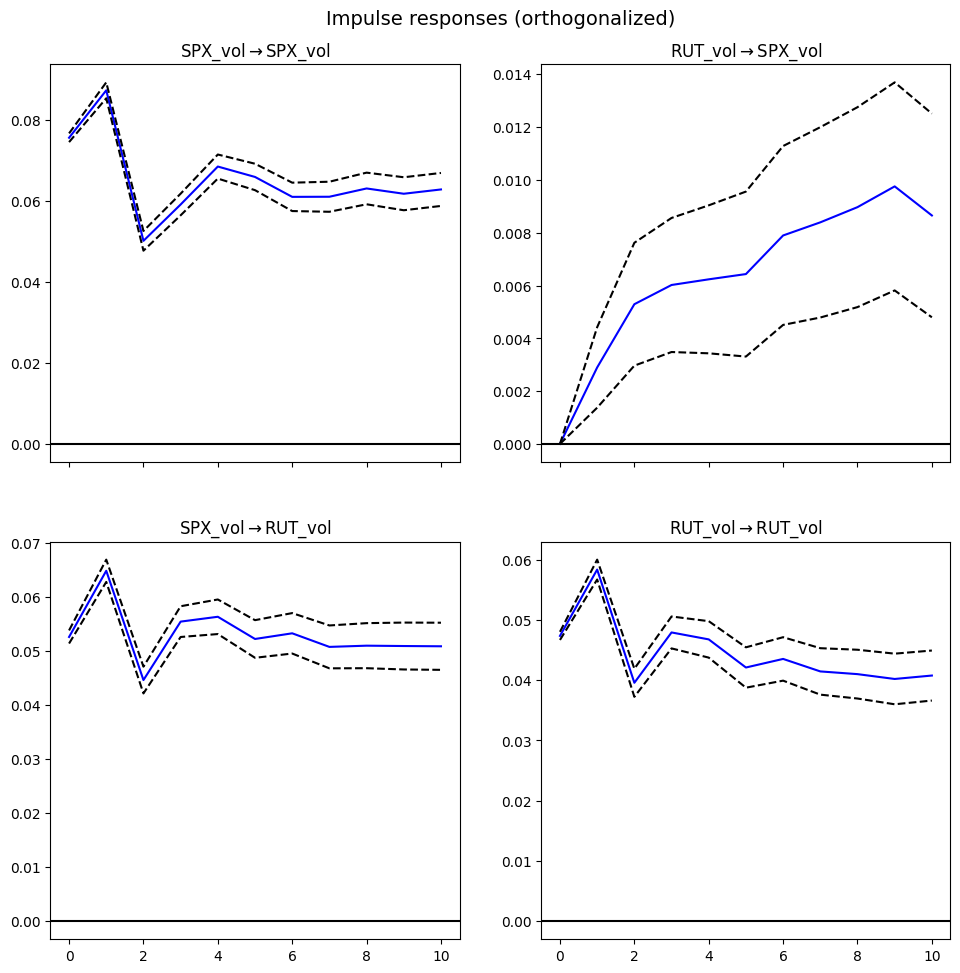

In [46]:
irf = results.irf(10)
irf.plot(orth=True)
plt.show()

## Extra Stuff (Not currently in use)

Stationarity Test

In [72]:
model = arch_model(resid*100, vol='GARCH', p=1, q=2, dist='normal')
model = model.fit(disp='off')

params = model.params
stationarity_sum = params['alpha[1]'] + params['beta[1]'] + params['beta[2]']

print(f"The Stationarity sum is {stationarity_sum}")

The Stationarity sum is 0.9838716209185968


In [ ]:
combined_data = pd.merge(gasoline_data, brent_data, left_index=True, right_index=True, suffixes=('_Gasoline', '_Brent')).dropna()

# GARCH with Brent Data as exogenous variable

model = arch_model(combined_data['Return_Gasoline'],  vol='GARCH', p=1, q=1, x=combined_data['Return_Brent'], dist='normal')
garchx_result = model.fit(disp='off')

#print(garchx_result.summary())
fitted_volatility = garchx_result.conditional_volatility

plt.figure(figsize=(14, 7))
plt.plot(fitted_volatility, label='Gasoline Conditional Volatility', color='blue', alpha=0.7)
plt.twinx()
plt.plot(combined_data['Return_Brent'], label='Brent Returns', color='red', alpha=0.4)
plt.title('Conditional Volatility of Gasoline Returns with Brent Returns')
plt.xlabel('Date')
plt.ylabel('Volatility / Returns')
plt.legend(loc='upper left')
plt.show()